In [2]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Property Assessment 2018
- Data is pulled from City of Edmonton Open Data portal.
- `nb` stands for neighbourhood
- The `ward` and `neighbourhood ID` columns are dropped from the DataFrame
    - The ward information is not understandable by the average homeowner
    - The neighbourhood name and ID are synonymous and present in all datasets 

### Set the correct data types for each of the remaining columns and reorder columns

In [3]:
col_names = ['acc_num', 'suite', 'number', 'street', 'value', 'class', 
             'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}
col_keep = ['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
             'garage', 'lat', 'long']

df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')[col_keep]

# Property Information 2018

In [4]:
col_names = ['acc_num', 'suite', 'number', 'street', 'legal_desc', 'zoning', 
             'lot_size', 'year_built', 'nb_id', 'nb', 'ward', 'lat', 'long']
col_dtypes = {'acc_num':np.int32, 'zoning':object, 'lot_size':object, 'year_built':object}
col_keep = ['acc_num', 'zoning', 'lot_size', 'year_built', 'nb']

df_info = pd.read_csv('Property_Information_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, low_memory=False)[col_keep]

### Remove and verify the number of null neighbourhood ID records
- This dataset contains one record without a neighbourhood ID.
    - This record has a substantially lower property assessment value.
    - This record represents an outlier in the nearly 400,000 records

In [5]:
df_null = df[df.nb.isnull()]
df_info_null = df_info[df_info.nb.isnull()]

df_cleaned = df[~df.nb.isnull()]
df_info_cleaned = df_info[~df_info.nb.isnull()]
print('The number of null neighbourhood records in df = {}'.format(len(df_null)))
print('The number of null neighbourhood records in df_info = {}'.format(len(df_info_null)))

The number of null neighbourhood records in df = 1
The number of null neighbourhood records in df_info = 1


## Merge the data and info DataFrames

### Filter the data for only the residential entries. To eliminate large malls and high-rises:

![West Edmonton Mall](WEM.png)

In [6]:
df_info_cleaned = df_info_cleaned[['acc_num', 'zoning', 'lot_size', 'year_built']]

df_clean = df_cleaned.merge(df_info_cleaned, on='acc_num')

df_clean = df_clean[df_clean['class'] == 'Residential']

# Edmonton Criminal Incidents by Neibourhood
- Data is pulled from City of Edmonton Open Data portal.
- The two data frames will be joined on `nb` neighbourhood name.

### Rename the columns more logically and to align with `df_cleaned`

In [7]:
col_list = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']
col_dtypes = {'nb':'category', 'violation':'category', 'year':str, 'month':str}
col_order = ['nb', 'violation', 'num_incidents', 'year', 'month', 'quarter']

df_crime = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', header=0, 
                      names=col_list, dtype=col_dtypes)[col_order]

### Convert `year` and `month` to a datetime column

In [8]:
datetime = pd.to_datetime(df_crime['year'] + '-' + df_crime['month'])

df_crime['record_month'] = datetime

df_crime = df_crime[['nb', 'violation', 'num_incidents', 'record_month']]

df_crime.set_index('record_month', inplace=True)

### Splice the crime data for only 2018 to avoid overexposing crime incidents in older neighbourhoods.

In [9]:
crime2018 = df_crime.loc['2018']
incidents2018 = crime2018.pivot_table(values='num_incidents', index='nb', 
                                      columns='violation', fill_value=0, aggfunc='sum')

### Merge the two dataframes to generate a complete and cleaned dataset
- Reset the index and drop the old index

- Filter on just the most recent crime data (2018)

In [10]:
property_assess = df_clean.merge(incidents2018, left_on='nb', right_index=True)
property_assess.reset_index(inplace=True)
property_assess.drop('index', axis=1, inplace=True)

### Assessment of property outliers

- Scatter plots
- order data

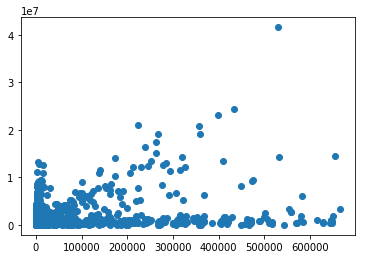

In [11]:
plt.scatter(property_assess['lot_size'], property_assess['value'])

plt.show()

### Properties that are assessed significantly higher than the median are privately owned residential complexes. 

#### As the following investigation of the `.max()` residential valuation shows:

![Griesbach Residential Complex](Residential Outlier.png)

### Properties that are assessed significantly lower than the median are small subdivided lots, primarily used for advertizing billboards.

In [12]:
# Significantly low residential property assessments:
aster = property_assess[property_assess['nb'] == 'ASTER']
industrial = property_assess[property_assess['nb'] == 'ELLERSLIE INDUSTRIAL']

# Maximum 
property_assess[property_assess['value'] == property_assess['value'].max()]

,acc_num,nb,class,value,suite,number,street,garage,lat,long,...,lot_size,year_built,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000
134120,10015454,GRIESBACH,Residential,41611500,NaN,14604,97 STREET NW,False,53.610393,-113.498265,...,530470,1960,14,12,0,1,1,27,12,0


In [13]:
property_assess.columns

Index(['acc_num', 'nb', 'class', 'value', 'suite', 'number', 'street',
       'garage', 'lat', 'long', 'zoning', 'lot_size', 'year_built', 'Assault',
       'Break and Enter', 'Homicide', 'Robbery', 'Sexual Assaults',
       'Theft From Vehicle', 'Theft Of Vehicle', 'Theft Over $5000'],
      dtype='object')

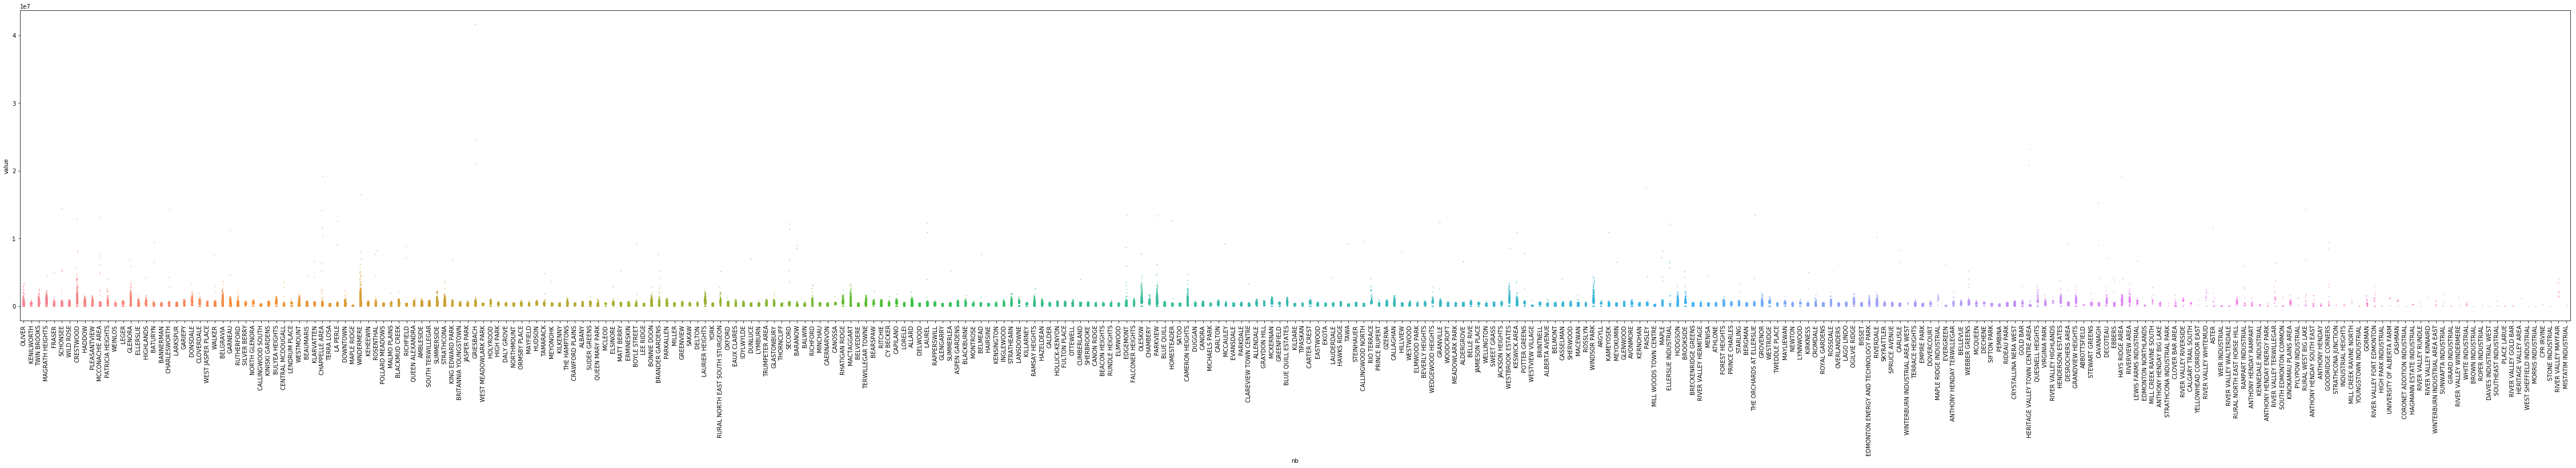

In [15]:
plt.figure(1, figsize=(80,10))

# Overlay a strip plot on the violin plot
sns.stripplot(x='nb', y='value', data=property_assess, size=1.5, jitter=True)

plt.xticks(rotation=90)

# Display the plot
plt.savefig('neighbourhood values.png')
plt.show()

## Some property assessments are for future developments:

![Aster Neighbourhood Investigation](Aster _NSP_Consolidation.pdf)

Text(0,0.5,'Assessed Value x 10 Billion (CAD)')

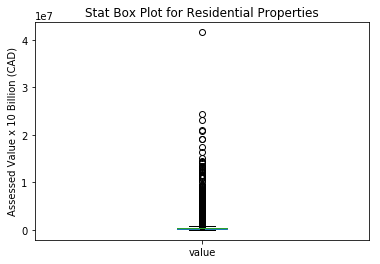

In [16]:
df_res = property_assess[property_assess['class'] == 'Residential']
ax = df_res['value'].plot(kind='box', title='Stat Box Plot for Residential Properties')
ax.set_ylabel('Assessed Value x 10 Billion (CAD)')

## Reshaping of data for analysis

In [17]:
df_grouped = df_cleaned.groupby(['nb']).mean()
df_grouped = df_grouped[['value']]

In [18]:
neighbourhood_assess = df_grouped.merge(incidents2018, left_on='nb', right_index=True)

nb_assess = neighbourhood_assess.reset_index()

## Example Analysis of Incident Type:

In [19]:
def incident_dist(incident):
    '''A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over $5000) and returns a histogram distribution.
    '''
    
    print('The maximum number of ' + incident + ' for any neighbourhood in Edmonton 2018 is: \n' 
          + str(nb_assess[incident].max()))
    print('\nThe neighbourhood with the most ' + incident + ' in 2018 is: \n' 
          + str(nb_assess[nb_assess[incident] == nb_assess[incident].max()].nb))
    
    ax = nb_assess[incident].plot(kind='hist',range=(0,nb_assess[incident].max()), bins=100, title=incident)
    ax.set_ylabel('Number of Neighbourhoods')
    ax.set_xlabel('Number of Incidents in 2018')
plt.show()

The maximum number of Assault for any neighbourhood in Edmonton 2018 is: 
283

The neighbourhood with the most Assault in 2018 is: 
96    DOWNTOWN
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]


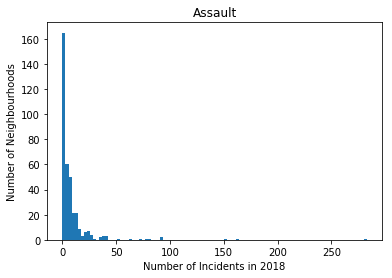

In [20]:
incident_dist('Assault')